In [1]:
import pandas as pd
import numpy as np
import pickle
# Importe as mesmas bibliotecas de scikit-learn e outras usadas para treinar o modelo
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, recall_score # Para avaliação, se valid.parquet tem labels
# Supondo que Model2VecEmbeddings está disponível
# from seu_modulo import Model2VecEmbeddings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import warnings

# --- Configurações ---
# Substitua pelos caminhos/nomes corretos
MODEL_PKL_PATH = r"C:\Users\fuedj\Documents\Code\NLP\desafio_DS\models\Negative_Recall_LR_AggloClust_Emb_v1\v1_final.pkl" # Caminho para o arquivo .pkl
VALID_DATA_PATH = r"C:\Users\fuedj\Documents\Code\NLP\desafio_DS\data\dataset_valid_with_sentiment_fix_negative.parquet" # Caminho para o arquivo de validação
TEXT_COLUMN = 'comment_cleaned' # Nome da coluna contendo o texto no valid.parquet
LABEL_COLUMN = 'sentiment' # Nome da coluna contendo os rótulos (se existir, para avaliação)

In [2]:
# --- Parâmetros do Melhor Modelo (Obtenha da run MLflow que logou o modelo) ---
# Estes DEVE ser exatamente os mesmos parâmetros que foram logados para o modelo final
# na run do MLflow. Você pode obtê-los diretamente da UI do MLflow ou se os salvou.

# Exemplo (substitua pelos seus valores reais):
LOGGED_MODEL_PARAMS = {
    'embedding_model': 'minishlab/potion-base-8M',
    'clustering_algorithm': 'KMeans', # Ou 'AgglomerativeClustering'
    'clustering_params': {'n_clusters': 3, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300}, # Parâmetros exatos do clustering
    'classification_model': 'LogisticRegression', # Ou 'RandomForestClassifier'
    'classification_model_params': {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'} # Parâmetros exatos do classificador
}

ALL_LABELS = ['Negative', 'Neutral', 'Positive'] # Seus rótulos originais

# --- Carregar o Modelo de Classificador Treinado ---
try:
    with open(MODEL_PKL_PATH, 'rb') as f:
        classifier_model = pickle.load(f)
    print(f"Modelo de classificador carregado com sucesso de: {MODEL_PKL_PATH}")
except FileNotFoundError:
    print(f"Erro: Arquivo de modelo não encontrado em {MODEL_PKL_PATH}")
    exit()
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    exit()

# --- Carregar os Dados de Validação ---
try:
    df_valid = pd.read_parquet(VALID_DATA_PATH)
    X_valid_text = df_valid[TEXT_COLUMN].tolist()
    if LABEL_COLUMN in df_valid.columns:
         y_valid = df_valid[LABEL_COLUMN].tolist()
         evaluation_available = True
         print(f"Dados de validação carregados com sucesso de: {VALID_DATA_PATH} (com labels para avaliação)")
    else:
         y_valid = None
         evaluation_available = False
         print(f"Dados de validação carregados com sucesso de: {VALID_DATA_PATH} (sem labels para avaliação)")

except FileNotFoundError:
    print(f"Erro: Arquivo de dados de validação não encontrado em {VALID_DATA_PATH}")
    exit()
except Exception as e:
    print(f"Erro ao carregar dados de validação: {e}")
    exit()


Modelo de classificador carregado com sucesso de: C:\Users\fuedj\Documents\Code\NLP\desafio_DS\models\Negative_Recall_LR_AggloClust_Emb_v1\v1_final.pkl
Dados de validação carregados com sucesso de: C:\Users\fuedj\Documents\Code\NLP\desafio_DS\data\dataset_valid_with_sentiment_fix_negative.parquet (com labels para avaliação)


In [3]:
from model2vec import StaticModel
from langchain.embeddings.base import Embeddings
from typing import List, Tuple, Dict

from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import pandas as pd
import numpy as np

class Model2VecEmbeddings(Embeddings):
    """Wrapper para o Model2Vec como Embeddings do LangChain"""
    def __init__(self, model_name: str = "minishlab/potion-base-2M", similarity_threshold: float = 0.85):
        self.model = StaticModel.from_pretrained(model_name)
        self.similarity_threshold = similarity_threshold

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return self.model.encode(texts).tolist()
    
    def embed_query(self, text: str) -> List[float]:
        return self.model.encode([text]).tolist()[0]
    
    def find_similar_pairs(self, embeddings: np.ndarray) -> List[Tuple[int, int]]:
        """Identifica pares similares usando similaridade de cosseno"""
        print("Calculando similaridades...")
        sim_matrix = cosine_similarity(embeddings)
        np.fill_diagonal(sim_matrix, 0)  # Ignora auto-similaridade
        
        similar_pairs = []
        n = sim_matrix.shape[0]
        
        # Encontra pares acima do threshold
        for i in tqdm(range(n), desc="Processando similaridades"):
            for j in range(i+1, n):
                if sim_matrix[i, j] > self.similarity_threshold:
                    similar_pairs.append((i, j))
        
        return similar_pairs

In [4]:
# Usando o caminho do seu código
df_train = pd.read_parquet('../data\dataset_train_trim_synthetic_balanced.parquet')

if 'target' not in df_train.columns:
    df_train['target'] = df_train['sentiment']

X_text = df_train['comment_cleaned']
y = df_train['target']

# --- Split de Treino e Teste ---
print("Realizando split de treino/teste...")
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

Realizando split de treino/teste...



Aplicando modelo de embedding...
Embeddings gerados com sucesso.
Shape dos embeddings de treino: (586, 256)
Shape dos embeddings de validação: (199, 256)

Aplicando algoritmo de clustering aos dados de treino...
Clustering 'KMeans' aplicado aos dados de treino.
Clusters de treino gerados. Unique IDs: [0 1 2]

Atribuindo clusters aos dados de validação...
Clusters atribuídos aos dados de validação.
Clusters de validação gerados. Unique IDs: [0 1 2]

Aumentando features dos dados de validação...
Features de validação aumentadas com sucesso. Shape: (199, 257)

Realizando inferência no conjunto de validação...
Inferência concluída.
Primeiras 10 predições: ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative']

Avaliando as predições...

Classification Report (Validation Set):
              precision    recall  f1-score   support

    Negative       0.25      1.00      0.40        50
     Neutral       0.00      0.00      0.

C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

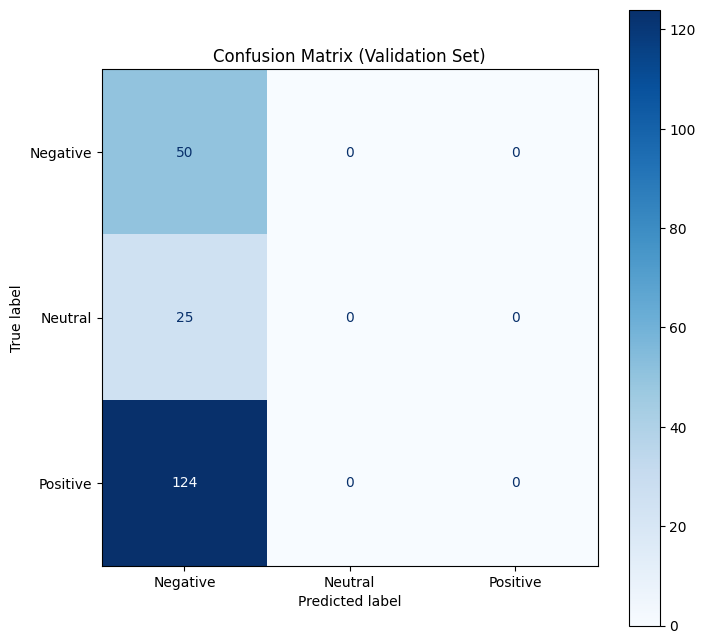


Script de inferência concluído.


In [5]:
# --- Reconstruir e Aplicar Etapas de Pré-processamento ---

# 1. Aplicar o Modelo de Embedding (no conjunto de TREINO ORIGINAL e VALIDAÇÃO)
# Para atribuir clusters aos dados de validação usando NearestNeighbors,
# precisamos dos embeddings originais do *conjunto de treino* que foram usados para FIT o clustering.
# Isso significa que você precisa ter acesso aos seus dados de treino originais (X_train_text)
# para re-gerar os embeddings de treino. Se você não tem acesso aos dados de treino originais,
# você pode ter que salvar os embeddings de treino originais no MLflow como um artefato
# durante o treinamento, ou considerar salvar o pipeline completo (embedding + clustering)
# em vez de apenas o classificador.

# *** Importante: Você precisa dos dados de treino originais ou dos embeddings de treino originais ***
# Vou assumir que você tem X_train_text e y_train disponíveis AQUI.
# Se não tiver, esta parte precisará ser adaptada.

# Exemplo (assumindo que X_train_text e y_train estão disponíveis):
# from seu_modulo_dados import X_train_text, y_train # Exemplo de importação dos dados de treino originais

print("\nAplicando modelo de embedding...")
embedding_model_name = LOGGED_MODEL_PARAMS['embedding_model']
# Re-instancie o modelo de embedding (assumindo que Model2VecEmbeddings está disponível)
try:
    embedding_model = Model2VecEmbeddings(embedding_model_name)
except Exception as e:
    print(f"Erro ao instanciar o modelo de embedding '{embedding_model_name}': {e}")
    print("Verifique se a classe Model2VecEmbeddings está correta e disponível.")
    exit()


# Gere embeddings para treino e validação
try:
    # Embeddings do treino (necessário para fitar o clustering e o NearestNeighbors)
    X_train_text_list = X_train_text.tolist() # Se X_train_text já não for lista
    X_train_vec = np.array(embedding_model.embed_documents(X_train_text_list))
    
    # Embeddings da validação
    X_valid_vec = np.array(embedding_model.embed_documents(X_valid_text))
    print("Embeddings gerados com sucesso.")
    print(f"Shape dos embeddings de treino: {X_train_vec.shape}")
    print(f"Shape dos embeddings de validação: {X_valid_vec.shape}")

except Exception as e:
    print(f"Erro ao gerar embeddings: {e}")
    exit()


# 2. Aplicar o Algoritmo de Clustering (no conjunto de TREINO ORIGINAL)
# O clustering FOI FITADO APENAS NOS DADOS DE TREINO DURANTE O TREINAMENTO.
# Precisamos re-fitar o mesmo algoritmo COM OS MESMOS PARÂMETROS
# nos embeddings de treino originais para obter os train_clusters corretos.

print("\nAplicando algoritmo de clustering aos dados de treino...")
cluster_algo_name = LOGGED_MODEL_PARAMS['clustering_algorithm']
cluster_params = LOGGED_MODEL_PARAMS['clustering_params']

try:
    if cluster_algo_name == "KMeans":
        clustering_model = KMeans(random_state=42, **cluster_params)
    elif cluster_algo_name == "AgglomerativeClustering":
        clustering_model = AgglomerativeClustering(**cluster_params)
    # Adicione outros algoritmos de clustering que você testou
    # elif cluster_algo_name == "Birch":
    #     from sklearn.cluster import Birch
    #     clustering_model = Birch(**cluster_params)
    else:
        print(f"Erro: Algoritmo de clustering '{cluster_algo_name}' não reconhecido ou não implementado para inferência.")
        exit()

    # Fit o clustering nos embeddings de treino
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # Suprime warnings de clustering se houverem
        try:
            # Tenta fit_predict que funciona para KMeans e Agglomerative com n_clusters
            train_clusters = clustering_model.fit_predict(X_train_vec)
        except (TypeError, AttributeError): # Se o fit_predict falhar, usa fit().labels_
            clustering_model.fit(X_train_vec)
            train_clusters = clustering_model.labels_

    print(f"Clustering '{cluster_algo_name}' aplicado aos dados de treino.")
    print(f"Clusters de treino gerados. Unique IDs: {np.unique(train_clusters)}")

except Exception as e:
    print(f"Erro ao aplicar clustering: {e}")
    exit()


# 3. Atribuir Clusters aos Dados de Validação usando Nearest Neighbors
# Usamos o mesmo método NN fitado nos embeddings de treino para atribuir IDs de cluster de treino
# aos pontos de validação.

print("\nAtribuindo clusters aos dados de validação...")
try:
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(X_train_vec) # Fita NN nos embeddings de treino (os mesmos usados para o clustering)
    _, indices = nn.kneighbors(X_valid_vec) # Encontra o vizinho mais próximo de cada ponto de VALIDAÇÃO nos pontos de TREINO
    valid_clusters = train_clusters[indices.flatten()] # Atribui o cluster ID do vizinho mais próximo de treino

    print("Clusters atribuídos aos dados de validação.")
    print(f"Clusters de validação gerados. Unique IDs: {np.unique(valid_clusters)}")

except Exception as e:
    print(f"Erro ao atribuir clusters aos dados de validação: {e}")
    exit()


# 4. Aumentar Features dos Dados de Validação
# Combina os embeddings de validação com seus IDs de cluster atribuídos.

print("\nAumentando features dos dados de validação...")
try:
    X_valid_aug = np.hstack([X_valid_vec, valid_clusters.reshape(-1, 1)])
    print(f"Features de validação aumentadas com sucesso. Shape: {X_valid_aug.shape}")
except Exception as e:
    print(f"Erro ao aumentar features de validação: {e}")
    exit()


# --- Fazer Inferência (Predições) no Conjunto de Validação ---
print("\nRealizando inferência no conjunto de validação...")
try:
    y_pred_valid = classifier_model.predict(X_valid_aug)
    print("Inferência concluída.")
    print(f"Primeiras 10 predições: {y_pred_valid[:10].tolist()}")
except Exception as e:
    print(f"Erro durante a inferência: {e}")
    exit()

# --- Opcional: Avaliar as Predições (se y_valid estiver disponível) ---
if evaluation_available:
    print("\nAvaliando as predições...")
    try:
        # Usar target_names=ALL_LABELS garante que o relatório inclua todas as classes, mesmo que
        # elas não apareçam nas predições ou nos rótulos verdadeiros deste conjunto específico.
        report_valid = classification_report(y_valid, y_pred_valid, target_names=ALL_LABELS)
        print("\nClassification Report (Validation Set):")
        print(report_valid)

        acc_valid = accuracy_score(y_valid, y_pred_valid)
        print(f"\nAccuracy (Validation Set): {acc_valid:.4f}")

        # Calcular Recall para a classe 'Negative' no conjunto de validação
        try:
             per_class_recall_valid = recall_score(y_valid, y_pred_valid, average=None, labels=ALL_LABELS, zero_division=0)
             neg_index = ALL_LABELS.index('Negative')
             neg_recall_valid = per_class_recall_valid[neg_index]
             print(f"Recall ('Negative') (Validation Set): {neg_recall_valid:.4f}")
        except Exception as e:
             print(f"Erro ao calcular recall negativo para validação: {e}")


        # Opcional: Gerar e exibir/salvar matriz de confusão para validação
        print("\nGerando Matriz de Confusão (Validation Set)...")
        cm_valid = confusion_matrix(y_valid, y_pred_valid, labels=ALL_LABELS)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=ALL_LABELS)
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title("Confusion Matrix (Validation Set)")
        plt.show()


    except Exception as e:
        print(f"Erro durante a avaliação: {e}")

print("\nScript de inferência concluído.")

# --- Opcional: Salvar Predições em um novo arquivo ---
# df_valid['predicted_label'] = y_pred_valid
# df_valid.to_parquet("path/to/your/valid_with_predictions.parquet")
# print("Predições salvas em valid_with_predictions.parquet")